In [1]:
import autograd.numpy as anp
from autograd import grad
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from functools import partial

In [2]:
def transition(particles, Q, n, noise):
    return 0.5 * particles + 25 * particles / (1 + particles ** 2) + 8 * anp.cos(1.2 * n) + noise

def likelihood_fn(particles, observation, R):
    predicted_observation = particles ** 2 / 20
    return anp.exp(-0.5 * ((predicted_observation - observation) ** 2) / R)

def systematic_resampling(particles, weights):
    N = len(weights)
    positions = (anp.arange(N) + anp.random.uniform()) / N
    indexes = anp.zeros(N, 'i')
    cumulative_sum = anp.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return particles[indexes]

def simulate_step(particles, observation, Q, R, step):
    noise = anp.random.normal(0, Q, size=particles.shape)
    particles = transition(particles, Q, step, noise)
    weights = likelihood_fn(particles, observation, R)
    weights += 1e-300  # Avoid division by zero
    weights /= anp.sum(weights)
    particles_resampled = systematic_resampling(particles, weights)
    state_estimate = anp.sum(particles_resampled * weights)
    return state_estimate, particles, weights, particles_resampled

def cost_function(params, particles, observation, step, noise):
    Q, R = params
    particles_trans = transition(particles, Q, step, noise)
    weights = likelihood_fn(particles_trans, observation, R)
    weights += 1e-300  # Avoid division by zero
    weights /= anp.sum(weights)
    state_estimate = anp.sum(particles_trans * weights)
    predicted_observation = state_estimate ** 2 / 20
    return (predicted_observation - observation) ** 2

def optimize_parameters(particles, observation, initial_params, noise):
    cost_function_partial = partial(cost_function, particles=particles, observation=observation, step=1, noise=noise)
    cost_grad = grad(cost_function_partial)
    result = minimize(cost_function_partial, initial_params, jac=cost_grad, method='BFGS')
    return result.x

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/var/folders/bm/09c1h4_j6dqg08r10fxlk1p40000gn/T/ipykernel_19347/1895664281.py:37: RuntimeWarning: invalid value encountered in divide
  weights /= anp.sum(weights)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in divide
  return f_raw(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in scalar power
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/var/folders/bm/09c1h4_j6dqg08r10fxlk1p40000gn/T/ipykernel_

Estimated Q: 10.0, Estimated R: 1.0
Estimated state: 2.5169980981386795


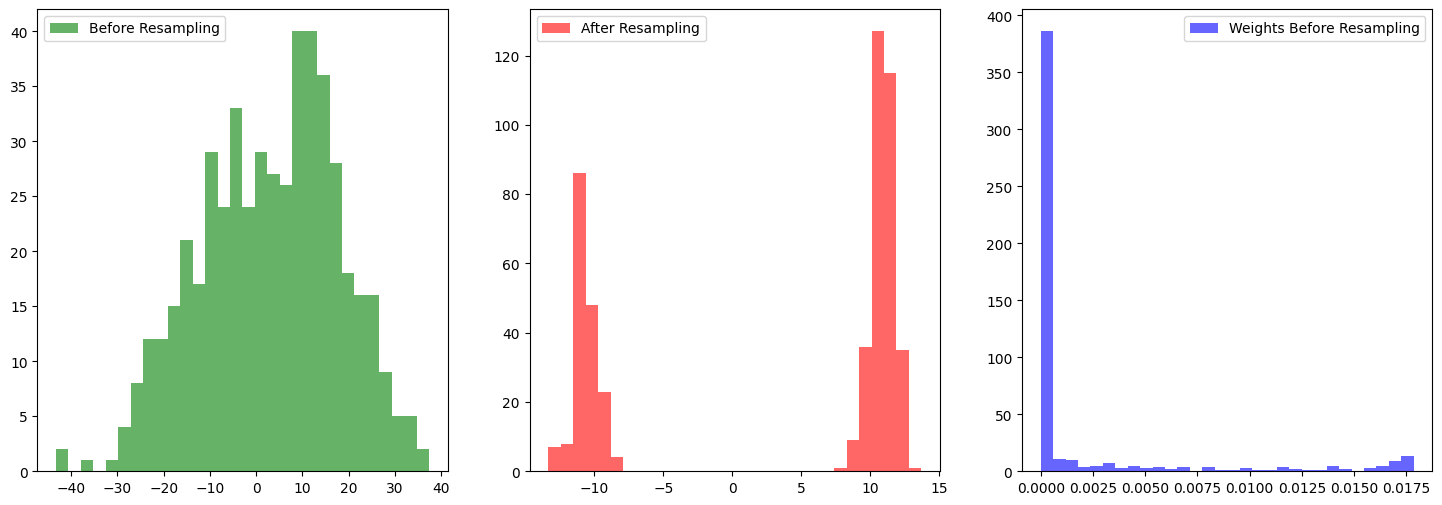

In [3]:
x0 = 0
Q = 10    
R = 1
numberIterations = 30
true_state = 10
observation = true_state ** 2 / 20 + anp.random.normal(0, R)
initial_params = anp.array([10.0, 1.0])
particles = anp.random.randn(500)
noise = anp.random.normal(0, initial_params[0], size=particles.shape)
optimized_params = optimize_parameters(particles, observation, initial_params, noise)
Q_opt, R_opt = optimized_params
print(f"Estimated Q: {Q_opt}, Estimated R: {R_opt}")
state_estimate, particles, weights, particles_resampled = simulate_step(particles, observation, Q_opt, R_opt, 1)
print(f"Estimated state: {state_estimate}")
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.hist(particles, bins=30, alpha=0.6, color='g', label='Before Resampling')
plt.legend()
plt.subplot(1, 3, 2)
plt.hist(particles_resampled, bins=30, alpha=0.6, color='r', label='After Resampling')
plt.legend()
plt.subplot(1, 3, 3)
plt.hist(weights, bins=30, alpha=0.6, color='b', label='Weights Before Resampling')
plt.legend()
plt.show()